In [59]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [60]:
##Daten zur Customer Personality Analysis:
df= pd.read_csv("data\marketing_campaign.csv", sep='\t')



In [61]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [62]:
# Drop null values
num_missing = df.apply( lambda x: any(x.isna()) ,axis=1).sum()
print(f"Number of rows with missing values: {num_missing}") 

# Only 24 columns with missing values, we can apply dropna function to the dataframe
df=df.dropna()

# Drop columns with only one value for all rows
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
df.drop(cols_to_drop, axis=1,inplace=True)

# Drop the ID column as it provides no information for analysis
df.drop("ID",axis=1,inplace=True)

# Drop outliers with Z-Score greater than 5, here we make an exception for #complains
numeric_df = df.select_dtypes(np.number).drop("Complain",axis=1)
filt = abs( stats.zscore(numeric_df,axis=0) )<=5
filt = filt.all(axis=1)
df = df.loc[ filt ]

# Drop columns with only one value for all rows after data cleaning
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
df.drop(cols_to_drop, axis=1,inplace=True)

print("The data is now clean")

Number of rows with missing values: 24
The data is now clean


In [63]:
# Numericalize education as years of higher education
df["Years of Higher Education"]=df["Education"].replace( {"Basic":0,"Master":6,"PhD":10,"Graduation":4,"2n Cycle":5} )

# Add age as feature
df["Age"] = 2015-df["Year_Birth"]
df=df.drop("Year_Birth",axis=1)

# Transform and numericalize Marital_Status as single/0 or Together/1
df["Marital_Status"].replace( ['Divorced', 'Widow', 'Alone','Absurd', 'YOLO'],'Single', inplace=True )
df["Numerical_Marital_Status"]=df["Marital_Status"].replace({"Single":0,"Together":1,"Married":1})

# Number of dependencies
df["Num_Dependencies"] = df["Kidhome"]+df["Teenhome"]

# Change the name of columns to be more decriptive
df.columns = [ colname.replace("Mnt","Spend on ") for colname in df.columns]

# Create a feature for total spend
df["Total Spend"] =  df[ [ 'Spend on Wines', 'Spend on Fruits',
       'Spend on MeatProducts', 'Spend on FishProducts',
       'Spend on SweetProducts', 'Spend on GoldProds' ] ].sum(axis=1)

# Drop the categorical columns
to_drop = ["Marital_Status", "Dt_Customer","Education"]
df.drop(to_drop, axis=1,inplace=True)



print(df.dtypes)
print("\nData frame is now all numerical")

Income                       float64
Kidhome                        int64
Teenhome                       int64
Recency                        int64
Spend on Wines                 int64
Spend on Fruits                int64
Spend on MeatProducts          int64
Spend on FishProducts          int64
Spend on SweetProducts         int64
Spend on GoldProds             int64
NumDealsPurchases              int64
NumWebPurchases                int64
NumCatalogPurchases            int64
NumStorePurchases              int64
NumWebVisitsMonth              int64
AcceptedCmp3                   int64
AcceptedCmp4                   int64
AcceptedCmp5                   int64
AcceptedCmp1                   int64
Complain                       int64
Response                       int64
Years of Higher Education      int64
Age                            int64
Numerical_Marital_Status       int64
Num_Dependencies               int64
Total Spend                    int64
dtype: object

Data frame is now all n

<AxesSubplot:>

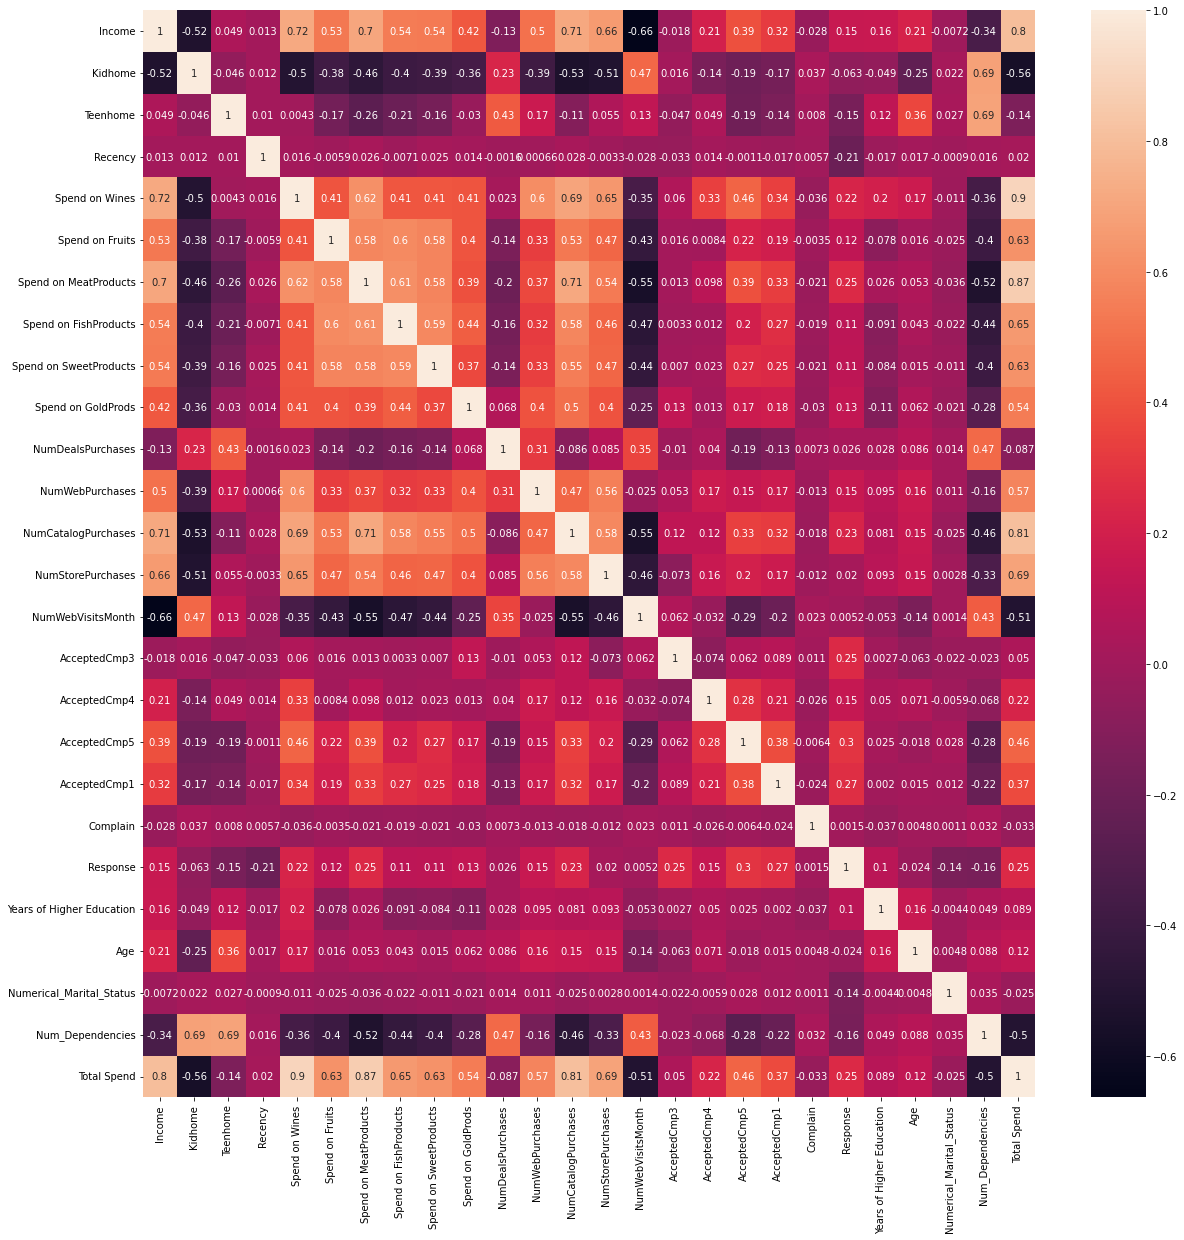

In [64]:
# Calculate the correlation matrix and visualized it as heat map

corr=df.corr()
plt.figure(figsize=(20,20)) 
sns.heatmap(corr,annot=True)

In [65]:
# Sort the correlation dataframe for ease of analysis
def zip_sort(x):
    sorted_ser = abs(x).sort_values(ascending=False)
    return pd.Series( zip( sorted_ser.index , x.loc[ sorted_ser.index ] ) )
def Sort_Correlated(corr):
    corr = corr.apply( zip_sort )
    return corr[1:].transpose()

sorted_corr = Sort_Correlated(corr)
sorted_corr

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
Income,"(Total Spend, 0.8036047706566107)","(Spend on Wines, 0.715882978719743)","(NumCatalogPurchases, 0.7099019244424642)","(Spend on MeatProducts, 0.7014182946177069)","(NumWebVisitsMonth, -0.663073017694985)","(NumStorePurchases, 0.6591315636506273)","(Spend on FishProducts, 0.5406215914491233)","(Spend on SweetProducts, 0.5378871707271023)","(Spend on Fruits, 0.5263400450485617)","(Kidhome, -0.5228484504749652)",...,"(Age, 0.2141987490013356)","(AcceptedCmp4, 0.20713358712670502)","(Years of Higher Education, 0.1599403808327332)","(Response, 0.1503967270383608)","(NumDealsPurchases, -0.1275970596460106)","(Teenhome, 0.04879145589676085)","(Complain, -0.027663827090803166)","(AcceptedCmp3, -0.01809316876157871)","(Recency, 0.012500881075176665)","(Numerical_Marital_Status, -0.007210343727599278)"
Kidhome,"(Num_Dependencies, 0.6869343678460531)","(Total Spend, -0.5597274162141495)","(NumCatalogPurchases, -0.5347080518370962)","(Income, -0.5228484504749652)","(NumStorePurchases, -0.5143005101754393)","(Spend on Wines, -0.5018010492487253)","(NumWebVisitsMonth, 0.46952584387300894)","(Spend on MeatProducts, -0.45750667617221336)","(Spend on FishProducts, -0.39706661008014943)","(NumWebPurchases, -0.3885434137762578)",...,"(AcceptedCmp5, -0.1938223715481955)","(AcceptedCmp1, -0.1652393665110356)","(AcceptedCmp4, -0.14343120918930347)","(Response, -0.06261308461192004)","(Years of Higher Education, -0.0492622696123759)","(Teenhome, -0.0461372451206927)","(Complain, 0.03659426552760407)","(Numerical_Marital_Status, 0.02168192653049881)","(AcceptedCmp3, 0.016148171026989868)","(Recency, 0.012434005438442511)"
Teenhome,"(Num_Dependencies, 0.6942523251305438)","(NumDealsPurchases, 0.42748557288524947)","(Age, 0.3633449192913641)","(Spend on MeatProducts, -0.26288400669640993)","(Spend on FishProducts, -0.20500172836029168)","(AcceptedCmp5, -0.1866853954837459)","(Spend on Fruits, -0.17356648176990352)","(NumWebPurchases, 0.16626694674145467)","(Spend on SweetProducts, -0.16255123179188982)","(Response, -0.15240404123820414)",...,"(NumStorePurchases, 0.0551684111127188)","(AcceptedCmp4, 0.04916013440528621)","(Income, 0.04879145589676085)","(AcceptedCmp3, -0.047013356575430494)","(Kidhome, -0.0461372451206927)","(Spend on GoldProds, -0.03030921672478026)","(Numerical_Marital_Status, 0.027075176337821888)","(Recency, 0.01008480002221794)","(Complain, 0.008026011399171825)","(Spend on Wines, 0.004328835595117334)"
Recency,"(Response, -0.2059129430826267)","(AcceptedCmp3, -0.033018462723336126)","(NumWebVisitsMonth, -0.028191053540690594)","(NumCatalogPurchases, 0.027549048547353003)","(Spend on MeatProducts, 0.02633535978017551)","(Spend on SweetProducts, 0.024962303859651952)","(Total Spend, 0.019896516719057625)","(AcceptedCmp1, -0.017363795677822574)","(Age, 0.01715143580071399)","(Years of Higher Education, -0.016865927501144...",...,"(Kidhome, 0.012434005438442511)","(Teenhome, 0.01008480002221794)","(Spend on FishProducts, -0.007058571615442959)","(Spend on Fruits, -0.005875981744683821)","(Complain, 0.005735242102007039)","(NumStorePurchases, -0.0032631692153803813)","(NumDealsPurchases, -0.001614337550674651)","(AcceptedCmp5, -0.0011090343153192764)","(Numerical_Marital_Status, -0.0009006291871613...","(NumWebPurchases, 0.0006591556790231541)"
Spend on Wines,"(Total Spend, 0.9012299910082329)","(Income, 0.715882978719743)","(NumCatalogPurchases, 0.694758477668525)","(NumStorePurchases, 0.6483744015160556)","(Spend on MeatProducts, 0.6215812339841893)","(NumWebPurchases, 0.6046425651180026)","(Kidhome, -0.5018010492487253)","(AcceptedCmp5, 0.45669398069185374)","(Spend on FishProducts, 0.409894826644595)","(Spend on SweetProducts, 0.4098435010062504)",...,"(AcceptedCmp4, 0.334021794461375)","(Response, 0.22418614978695434)","(Years of Higher Education, 0.19840546012563648)","(Age, 0.1703630680787406)","(AcceptedCmp3, 0.0597281625161497)","(Complain, -0.035677648585537215)"

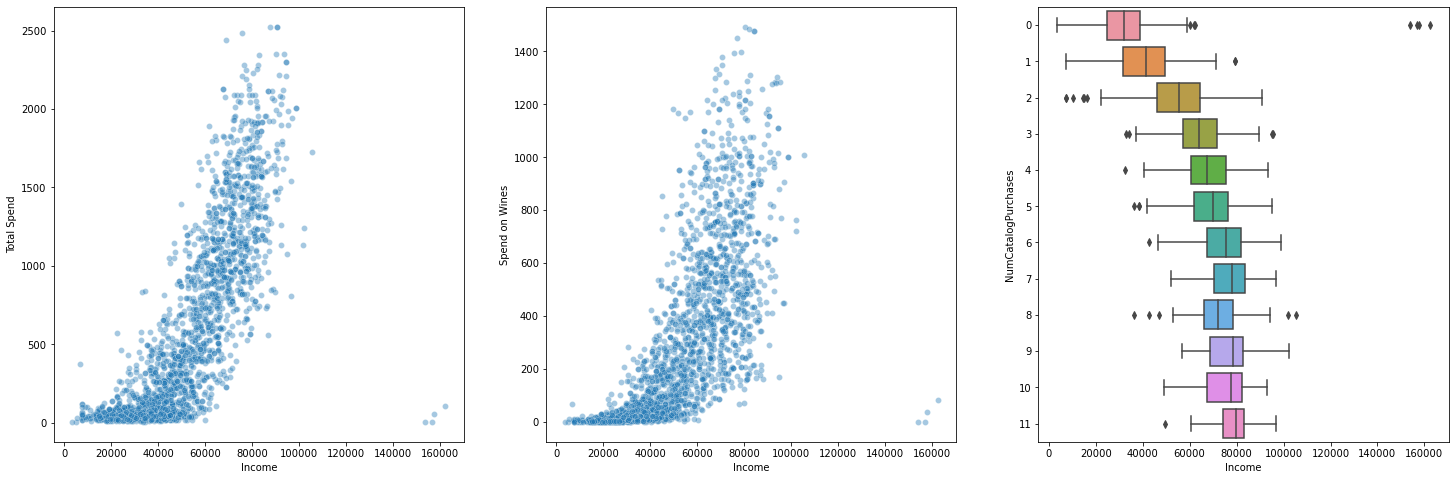

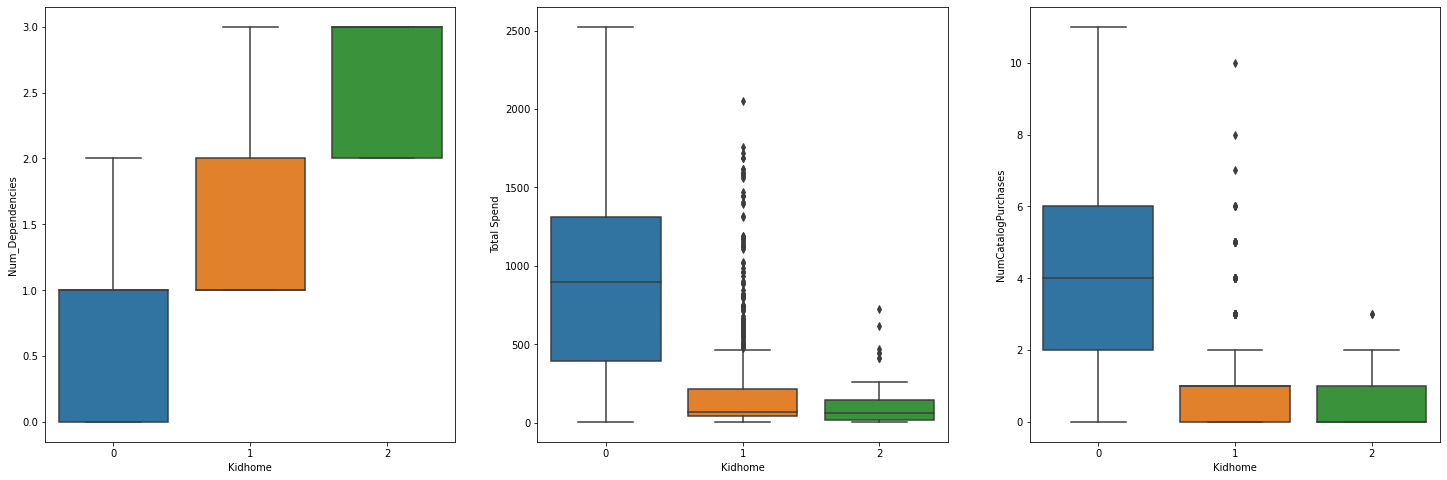

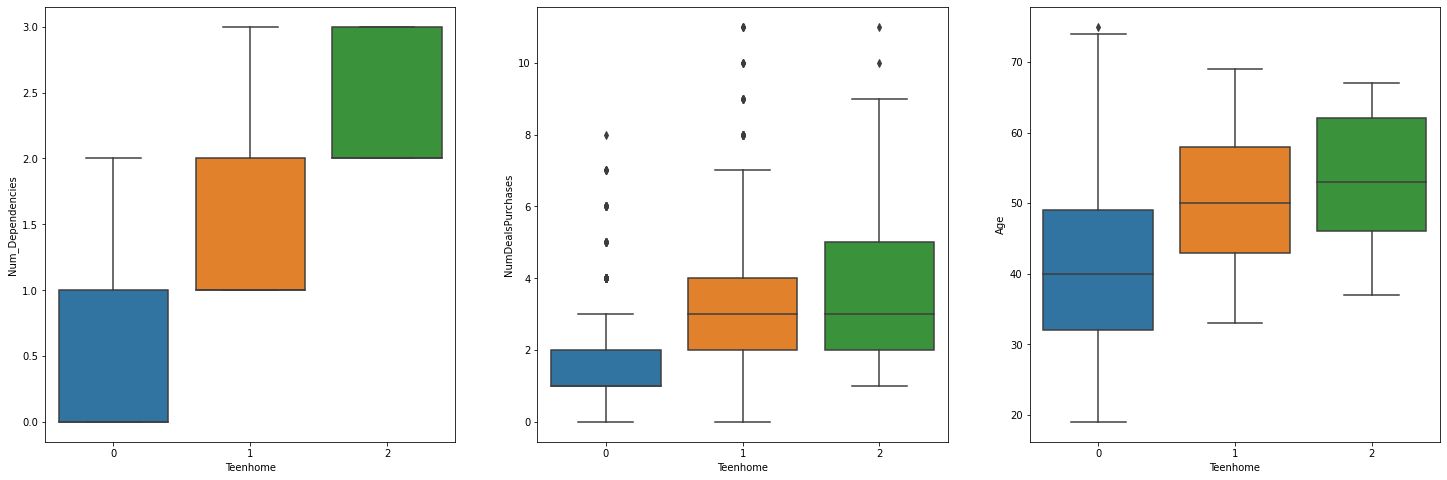

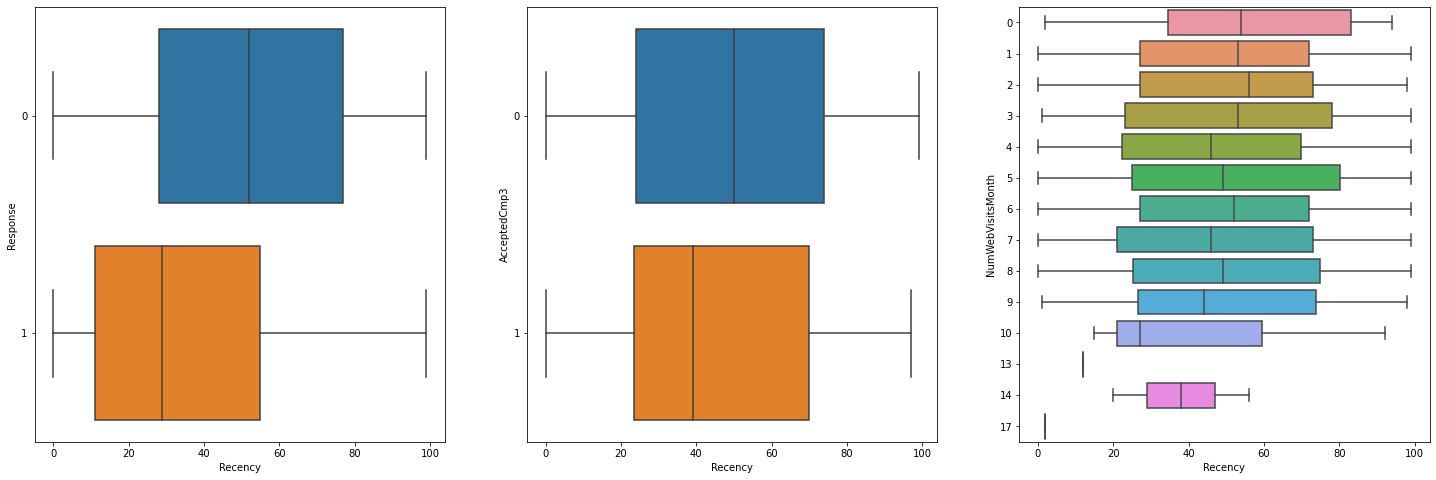

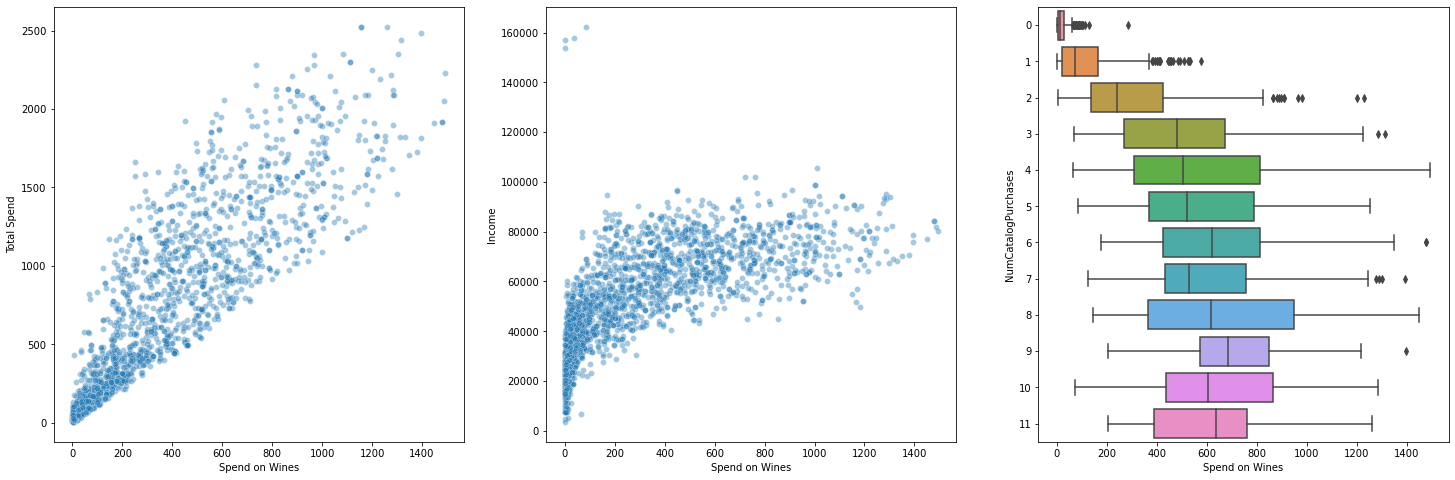

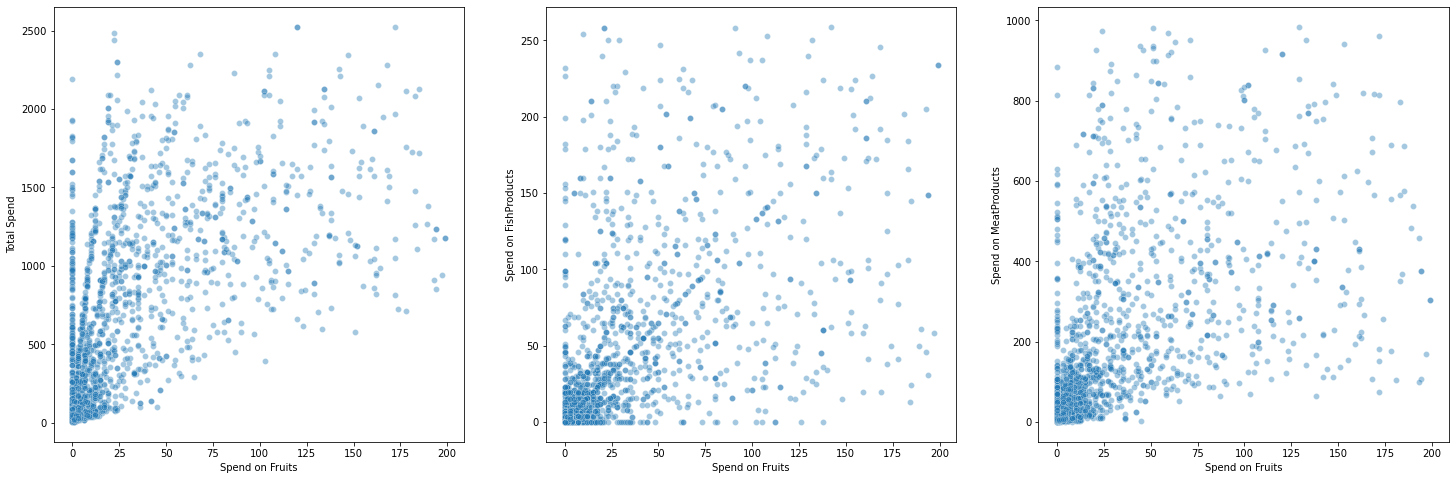

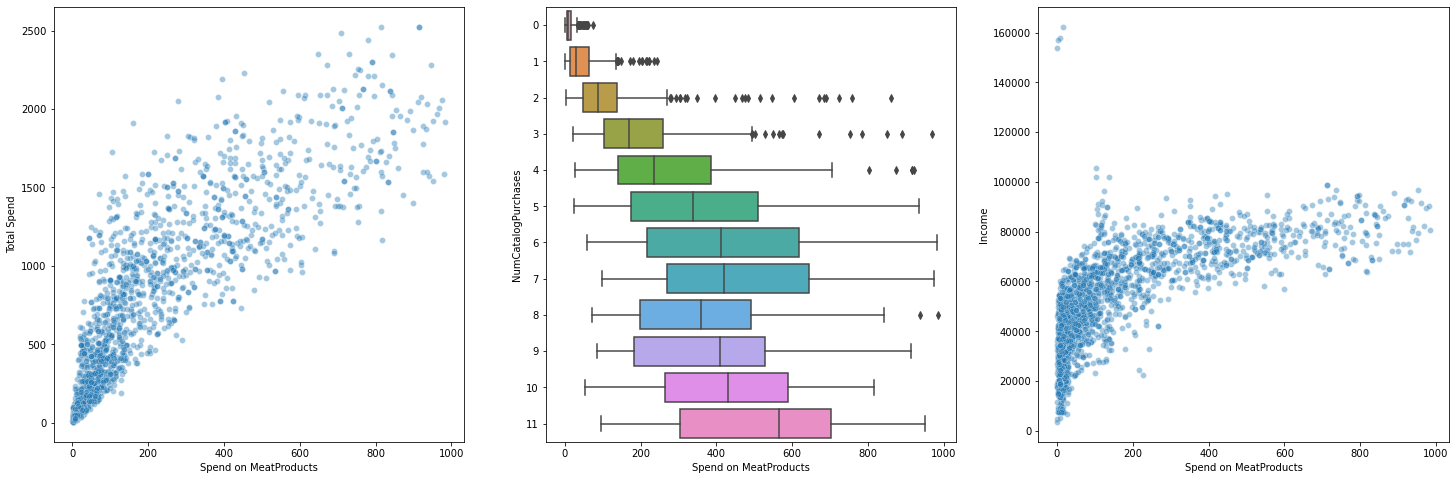

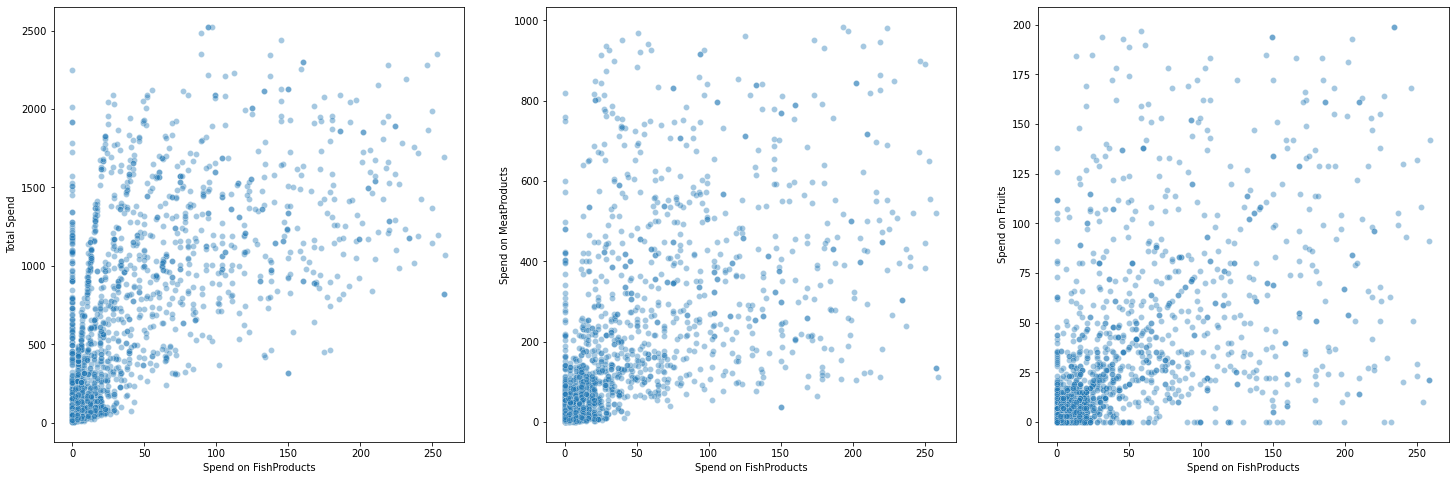

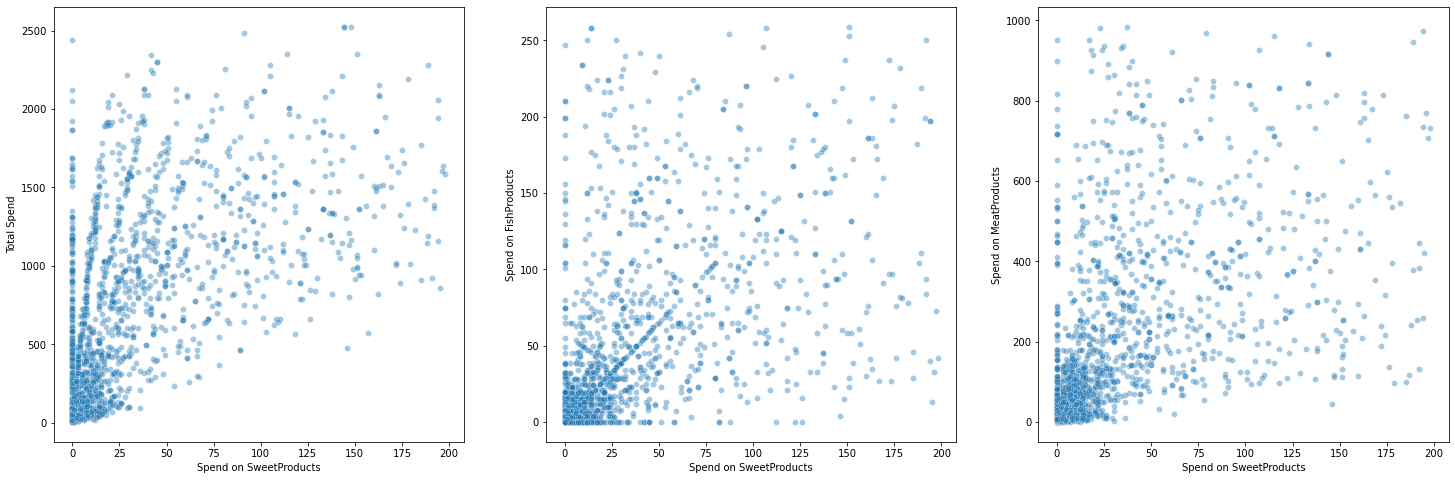

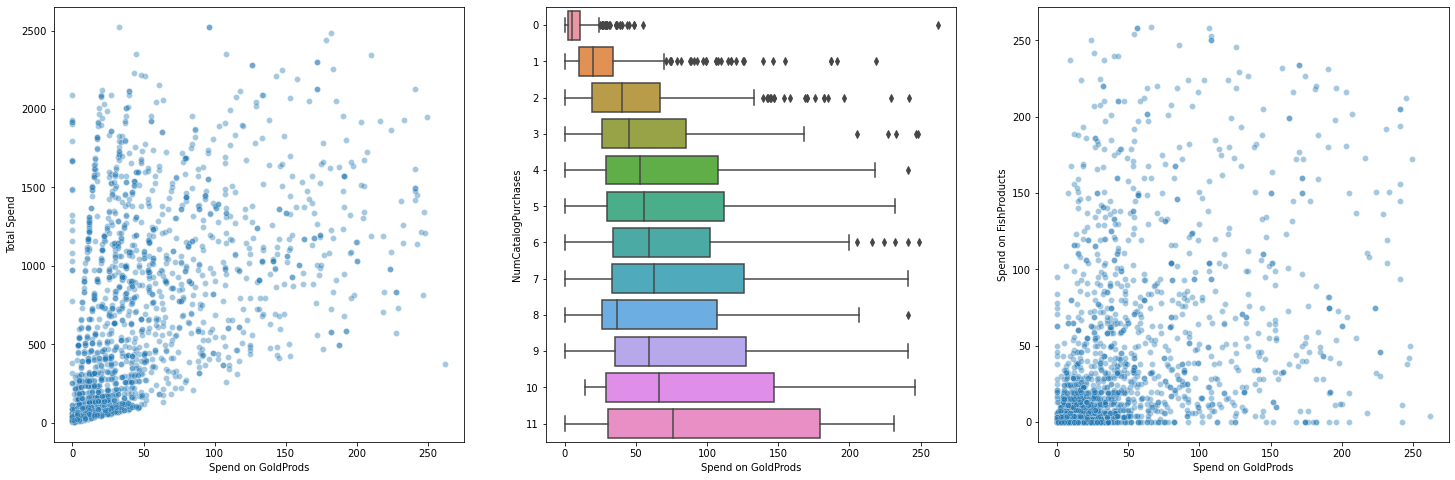

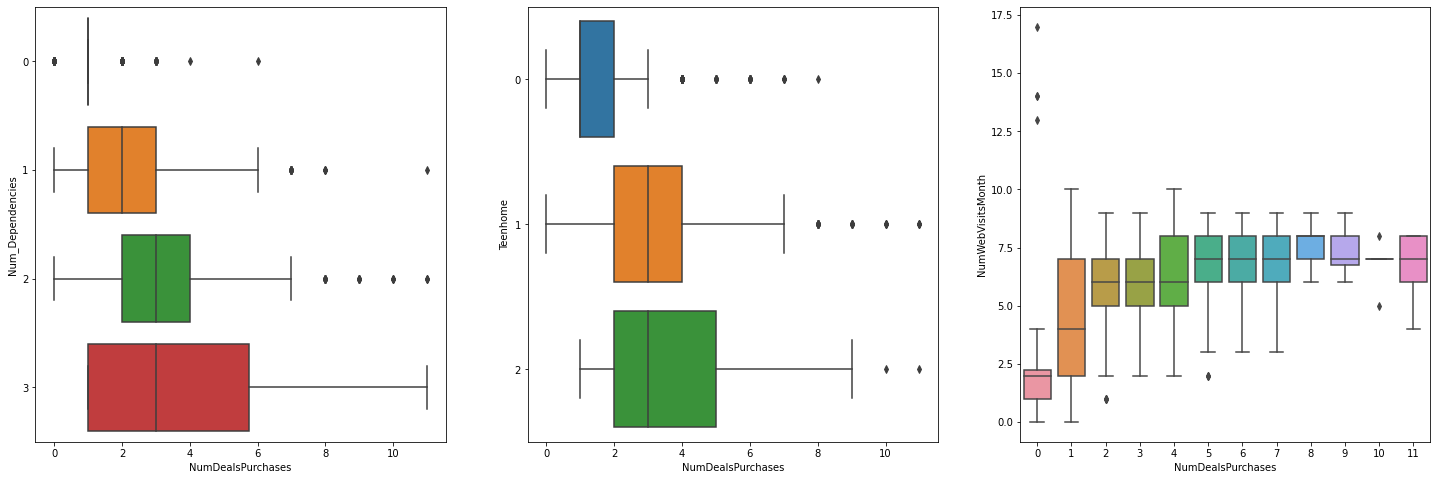

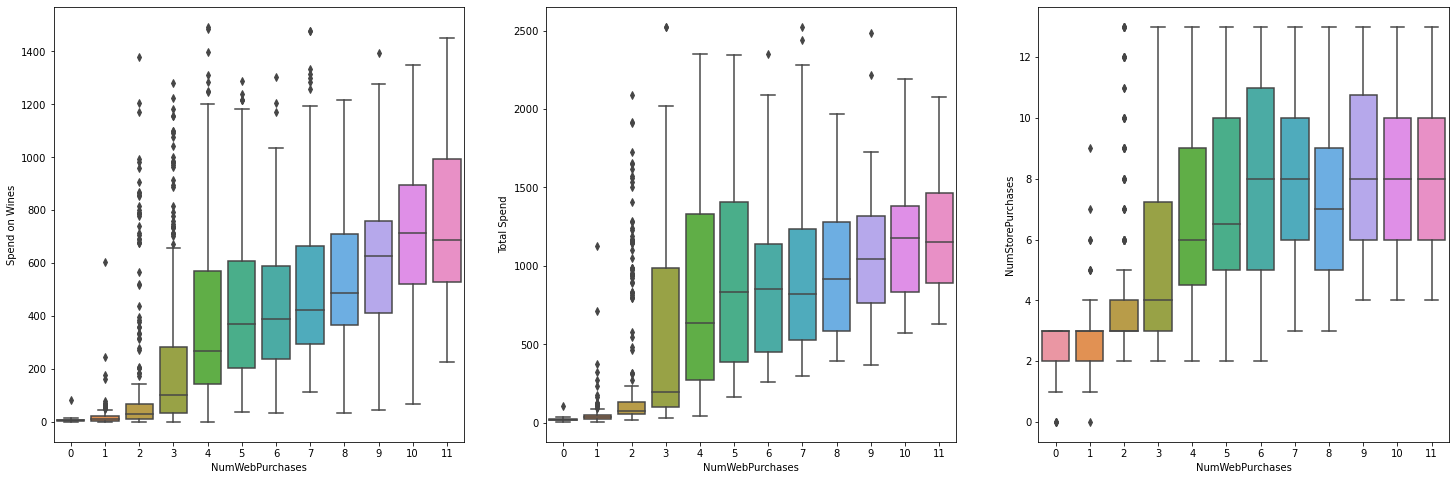

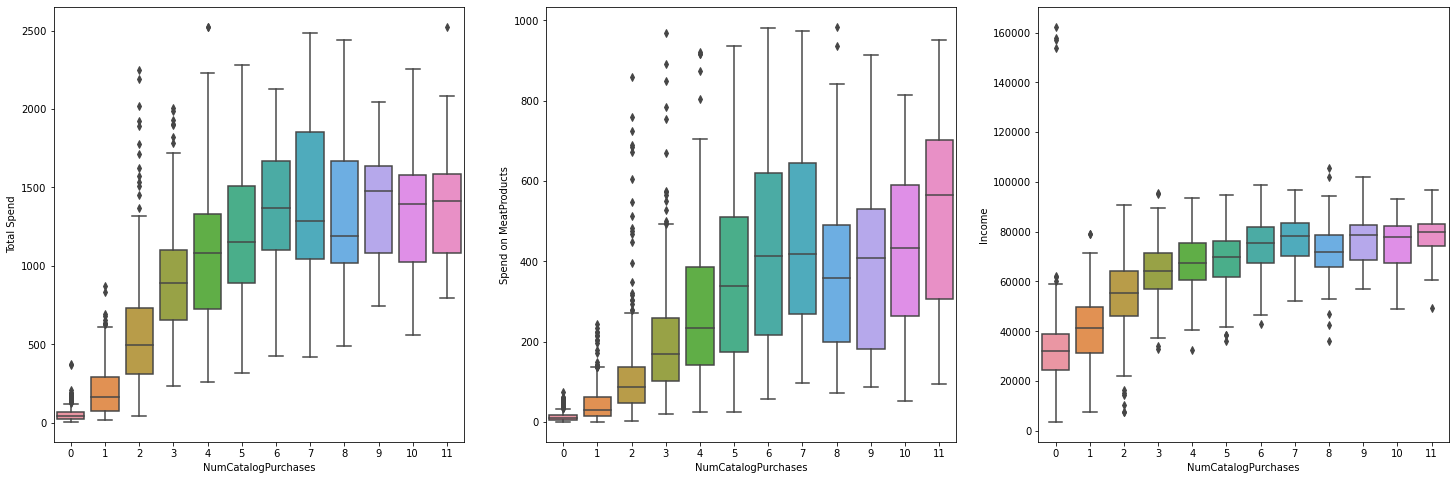

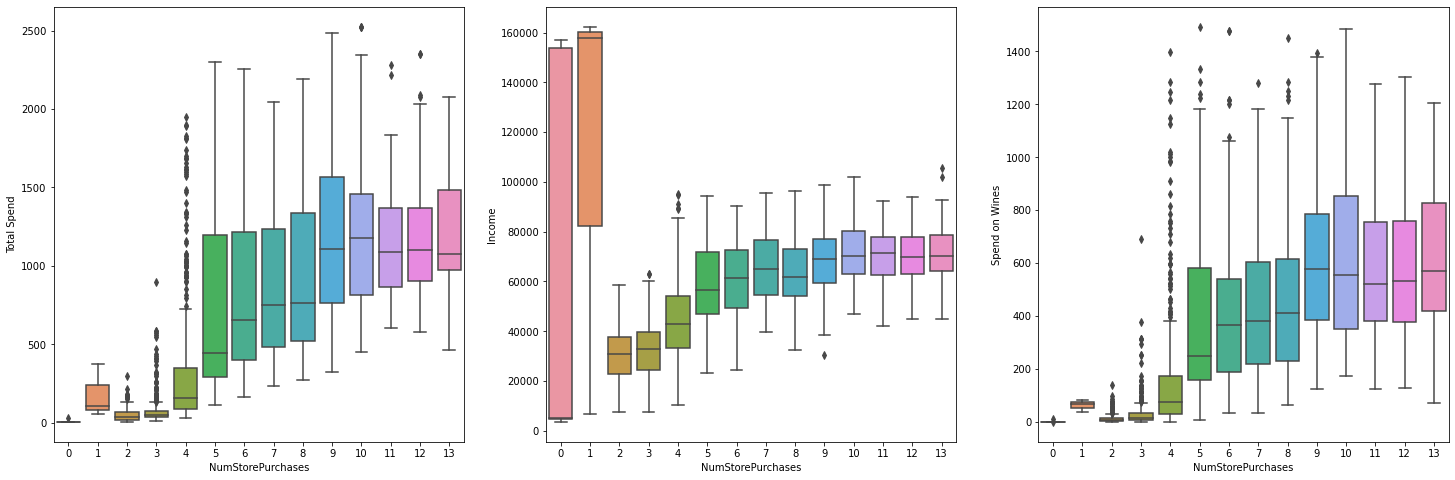

In [ ]:
# Create boxplot or scatterplot for the top 3 most correlated pair base on number of unique values in each feature
response_cols = ['AcceptedCmp1', 'AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5', 'Response']
sorted_corr.drop(index = response_cols,inplace=True)
for index,row in sorted_corr.iterrows():
    fig, ax =plt.subplots(1,3)
    fig.set_size_inches(25,8)
    i=0
    
    for pair in row[:3]:
        x_unique = df[index].nunique()
        y_unique = df[pair[0]].nunique()
        
        if x_unique<=20 or y_unique<=20:
            if x_unique<y_unique:
                sns.boxplot(x=df[index],y=df[pair[0]],ax=ax[i],orient="v")
            else:
                sns.boxplot(x=df[index],y=df[pair[0]],ax=ax[i],orient="h")
        else:
            sns.scatterplot(x=df[index],y=df[pair[0]],ax=ax[i],alpha=0.4)
        i+=1
    plt.show()